In [2]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [1]:
! pip install tensorflow==2.4.1

In [4]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import os
import random

In [5]:
theSEED = 232323
tf.random.set_seed(theSEED)
np.random.seed(theSEED)
random.seed(theSEED)

In [16]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 10      # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!mkdir -p '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
!gdown --id '14CuNJzfpF-HCOcgYXE1XF0umKIxCScB7' -O '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip'

In [ ]:
!unzip '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip' -d '/content/gdrive/MyDrive/Curso-Jetson/imagenes/'

In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits'

Test  Training


In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training'

Banana	Lemon  Orange  Strawberry


In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dataset', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dataset', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 272 files belonging to 4 classes.
Using 218 files for training.
Found 272 files belonging to 4 classes.
Using 54 files for validation.


In [9]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

A partir de aquí solucionaremos el overfitting:

Vamos a visualizar una de las muestras y la clase a la que pertenece:

In [24]:
def process(image,label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
# Create a pretrained model.
base_model = tf.keras.applications.MobileNetV2(
  input_tensor=None, include_top=False, 
  weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

model = tf.keras.Sequential()
#model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.build((None, 224,224,3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               384300    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

In [14]:
model.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 19s 603ms/step - loss: 1.4829 - accuracy: 0.3806 - val_loss: 0.7126 - val_accuracy: 0.8148
Epoch 2/10
7/7 [==============================] - 13s 492ms/step - loss: 0.5109 - accuracy: 0.8554 - val_loss: 0.3597 - val_accuracy: 0.8704
Epoch 3/10
7/7 [==============================] - 13s 494ms/step - loss: 0.3099 - accuracy: 0.8806 - val_loss: 0.1147 - val_accuracy: 0.9815
Epoch 4/10
7/7 [==============================] - 13s 492ms/step - loss: 0.1267 - accuracy: 0.9492 - val_loss: 0.1259 - val_accuracy: 0.9444
Epoch 5/10
7/7 [==============================] - 13s 495ms/step - loss: 0.0494 - accuracy: 0.9867 - val_loss: 0.0636 - val_accuracy: 0.9815
Epoch 6/10
7/7 [==============================] - 13s 491ms/step - loss: 0.1323 - accuracy: 0.9386 - val_loss: 0.0739 - val_accuracy: 0.9815
Epoch 7/10
7/7 [==============================] - 13s 496ms/step - loss: 0.0460 - accuracy: 0.9880 - val_loss: 0.0481 - val_accuracy: 0.9815
Epoch 8/10
7/

In [29]:
model.evaluate(val_ds)

2/2 [==============================] - 4s 69ms/step - loss: 0.0234 - accuracy: 1.0000


[0.023434115573763847, 1.0]

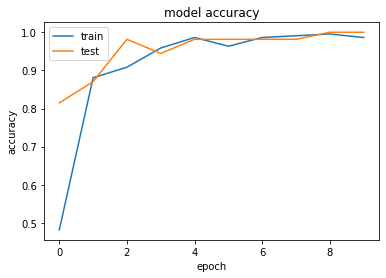

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

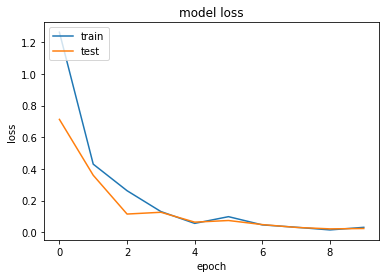

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model.layers.pop(0)
#model.layers.pop(0)
newInput = tf.keras.layers.Input(batch_shape=(None,224,224,3))
newOutputs = model(newInput)
newModel = tf.keras.Model(newInput, newOutputs)
newModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 4)                 2672788   
Total params: 2,672,788
Trainable params: 414,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
newModel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
newModel.evaluate(val_ds)

2/2 [==============================] - 6s 61ms/step - loss: 0.0249 - accuracy: 1.0000


[0.023434104397892952, 1.0]

In [36]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-pract2.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-pract2'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model-final-pract2/assets


In [35]:
!ls $OUT_MODEL_PATH

model-final-proj  model-final-proj.hdf5
